In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def calculate_dice(y_true, y_pred, threshold=0.5):
    """
    Calcula el coeficiente de Dice entre las predicciones y las etiquetas reales.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
        
    Returns:
        float: Valor promedio de Dice.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    dice = (2 * intersection + 1e-6) / (y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) + 1e-6)
    return dice.mean().item()
def calculate_iou(y_true, y_pred, threshold=0.5):
    """
    Calcula el IoU entre las predicciones y las etiquetas reales.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
        
    Returns:
        float: Valor promedio de IoU.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    union = y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Evitar división por 0
    return iou.mean().item()
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calcula varias métricas en porcentaje para evaluar el modelo.
    """
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    TP = (y_pred * y_true).sum().item()  # Verdaderos positivos
    FP = (y_pred * (1 - y_true)).sum().item()  # Falsos positivos
    FN = ((1 - y_pred) * y_true).sum().item()  # Falsos negativos
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()  # Verdaderos negativos

    # Evitar divisiones por 0
    epsilon = 1e-6

    accuracy = ((TP + TN) / (TP + TN + FP + FN + epsilon)) * 100
    precision = (TP / (TP + FP + epsilon)) * 100
    recall = (TP / (TP + FN + epsilon)) * 100
    f1 = (2 * precision * recall / (precision + recall + epsilon))
    iou = (TP / (TP + FP + FN + epsilon)) * 100

    return {
        "Accuracy (%)": accuracy,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1,
        "IoU (%)": iou
    }
def load_dataset(root_dir):
    """
    Carga todas las imágenes, etiquetas de segmentación y etiquetas de clasificación.
    
    Args:
        root_dir (str): Ruta de la carpeta raíz que contiene las carpetas kosXX.

    Returns:
        images (list): Lista de arrays de imágenes.
        segmentation_labels (list): Lista de arrays de etiquetas de segmentación.
        classification_labels (list): Lista de etiquetas de clasificación (OK/NOK).
    """
    images = []
    segmentation_labels = []
    classification_labels = []
    images_augmented = []
    segmentation_labels_augmented = []
    classification_labels_augmented = []

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):
            for file in sorted(os.listdir(folder_path)):
                file_path = os.path.join(folder_path, file)

                if file.endswith(".jpg"):  # Imágenes
                    img = Image.open(file_path).convert("L")
                    img_array = np.array(img) / 255.0  # Normalizar a [0, 1]
                    if "aug" in file:  # Datos aumentados
                        images_augmented.append(img_array)
                    else:
                        images.append(img_array)

                elif file.endswith(".bmp"):  # Mapas de bits (segmentación)
                    label = Image.open(file_path).convert("L")
                    label_array = np.array(label) / 255.0  # Normalizar a [0, 1]
                    classification_label = 1 if np.sum(label_array) > 0 else 0  # OK = 0, NOK = 1
                    if "aug" in file:  # Datos aumentados
                        segmentation_labels_augmented.append(label_array)
                        classification_labels_augmented.append(classification_label)
                    else:
                        segmentation_labels.append(label_array)
                        classification_labels.append(classification_label)

    return (images, segmentation_labels, classification_labels,
            images_augmented, segmentation_labels_augmented, classification_labels_augmented)

In [3]:
# Ruta de la carpeta raíz
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Imagenes_defectos"
(images, segmentation_labels, classification_labels,
 images_augmented, segmentation_labels_augmented, classification_labels_augmented) = load_dataset(root_dir)

# Imprimir información del dataset
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas de segmentacion cargadas: {len(segmentation_labels)}")
print(f"Número de etiquetas de clasificacion cargadas: {len(classification_labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas de segmentacion augmented cargadas: {len(segmentation_labels_augmented)}")
print(f"Número de etiquetas de clasificacion augmented cargadas: {len(classification_labels_augmented)}")
# Agregar datos aumentados
images += images_augmented
segmentation_labels += segmentation_labels_augmented
classification_labels += classification_labels_augmented

# Normalizar imágenes y etiquetas
images = [img for img in images]
segmentation_labels = [label for label in segmentation_labels]

# Dividir en conjuntos de entrenamiento, validación y prueba
train_images, test_images, train_seg_labels, test_seg_labels, train_class_labels, test_class_labels = train_test_split(
    images, segmentation_labels, classification_labels, test_size=0.2, random_state=40
)

val_images, test_images, val_seg_labels, test_seg_labels, val_class_labels, test_class_labels = train_test_split(
    test_images, test_seg_labels, test_class_labels, test_size=0.5, random_state=40
)
from torchvision import transforms

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])

# Transformaciones para las etiquetas
label_transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])

Número de imágenes cargadas: 399
Número de etiquetas de segmentacion cargadas: 399
Número de etiquetas de clasificacion cargadas: 399
Número de imágenes augmented cargadas: 280
Número de etiquetas de segmentacion augmented cargadas: 280
Número de etiquetas de clasificacion augmented cargadas: 280


In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, segmentation_labels, classification_labels, transform=None, label_transform=None):
        self.images = images
        self.segmentation_labels = segmentation_labels
        self.classification_labels = classification_labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        segmentation_label = Image.fromarray(self.segmentation_labels[idx])
        classification_label = torch.tensor(self.classification_labels[idx], dtype=torch.float32).unsqueeze(0)  # Agregar dimensión
    
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            segmentation_label = self.label_transform(segmentation_label)
    
        return image, (segmentation_label, classification_label)



# Crear datasets
train_dataset = CustomDataset(
    images=train_images,
    segmentation_labels=train_seg_labels,
    classification_labels=train_class_labels,
    transform=transform,
    label_transform=label_transform
)

val_dataset = CustomDataset(
    images=val_images,
    segmentation_labels=val_seg_labels,
    classification_labels=val_class_labels,
    transform=transform,
    label_transform=label_transform
)

test_dataset = CustomDataset(
    images=test_images,
    segmentation_labels=test_seg_labels,
    classification_labels=test_class_labels,
    transform=transform,
    label_transform=label_transform
)

def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=1)
    )


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        self.bottleneck = self.conv_block(128, 256)

        # Branch 1: Mapas de bits (Segmentación)
        self.up4 = self.upconv(256, 128)
        self.dec4 = self.conv_block(256, 128)  # Ajustado
        self.up3 = self.upconv(128, 64)
        self.dec3 = self.conv_block(128, 64)  # Ajustado
        self.up2 = self.upconv(64, 32)
        self.dec2 = self.conv_block(64, 32)  # Ajustado
        self.up1 = self.upconv(32, 16)
        self.dec1 = self.conv_block(32, 16)  # Ajustado
        self.final_segmentation = nn.Conv2d(16, out_channels, kernel_size=1)

        # Branch 2: Clasificación binaria (OK/NOK)
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Branch 1: Mapas de bits (Segmentación)
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        segmentation_output = self.final_segmentation(dec1)

        # Branch 2: Clasificación
        classification_output = self.classification_head(bottleneck)

        return segmentation_output, classification_output
batch_size = 15
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\jerij\AppData\Local\Temp\ipykernel_11240\3167053372.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_loca

Se han cargado 3 modelos.


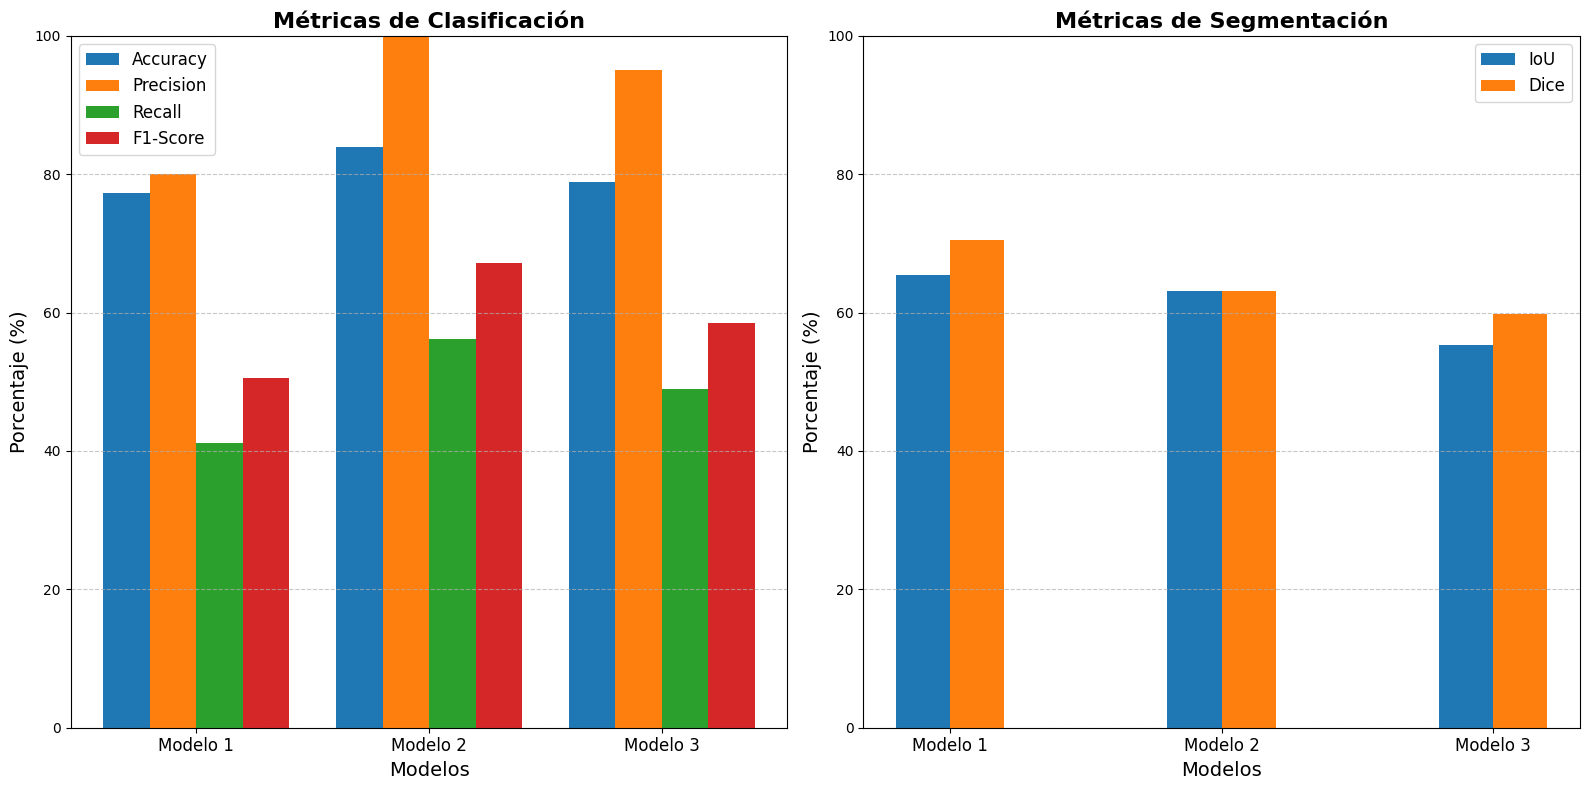

In [7]:
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calcula varias métricas en porcentaje para evaluar el modelo.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas en porcentaje.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    y_true = y_true.float()  # Asegurar que las etiquetas sean float

    # Calcular métricas básicas
    TP = (y_pred * y_true).sum().item()  # Verdaderos positivos
    FP = (y_pred * (1 - y_true)).sum().item()  # Falsos positivos
    FN = ((1 - y_pred) * y_true).sum().item()  # Falsos negativos
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()  # Verdaderos negativos

    # Evitar divisiones por 0
    epsilon = 1e-6

    # Métricas
    accuracy = ((TP + TN) / (TP + TN + FP + FN + epsilon)) * 100
    precision = (TP / (TP + FP + epsilon)) * 100
    recall = (TP / (TP + FN + epsilon)) * 100
    f1 = (2 * precision * recall / (precision + recall + epsilon))
    iou = (TP / (TP + FP + FN + epsilon)) * 100

    return {
        "Accuracy (%)": accuracy,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1,
        "IoU (%)": iou
    }


def evaluate_model(model, test_loader, threshold=0.5):
    """
    Evalúa el modelo en el conjunto de prueba y calcula métricas promedio.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        test_loader (DataLoader): DataLoader del conjunto de prueba.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas promedio en porcentaje.
    """
    model.eval()
    all_metrics = {
        "Accuracy (%)": [],
        "Precision (%)": [],
        "Recall (%)": [],
        "F1-Score (%)": [],
        "IoU (%)": []
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = torch.sigmoid(model(images))  # Aplicar Sigmoid

            # Calcular métricas para cada batch
            metrics = calculate_metrics(labels, outputs, threshold)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])

    # Promediar las métricas
    averaged_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    return averaged_metrics


import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import numpy as np

def compare_models(models, test_loader, threshold=0.5, device=DEVICE):
    """
    Compara gráficamente el rendimiento de múltiples modelos en términos de métricas de clasificación y segmentación.

    Args:
        models (list): Lista de modelos entrenados.
        test_loader (DataLoader): DataLoader con las imágenes y etiquetas del conjunto de prueba.
        threshold (float): Umbral para binarizar las predicciones.
        device (torch.device): Dispositivo en el que se ejecutarán los modelos.
    """
    classification_metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}
    segmentation_metrics = {"IoU": [], "Dice": []}
    model_names = [f"Modelo {i+1}" for i in range(len(models))]

    for i, model in enumerate(models):
        model.eval()
        model.to(device)

        class_metrics = {"Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}
        seg_metrics = {"IoU": [], "Dice": []}

        with torch.no_grad():
            for images, (segmentation_labels, classification_labels) in test_loader:
                images = images.to(device)
                segmentation_labels = segmentation_labels.to(device)
                classification_labels = classification_labels.to(device)

                # Obtener predicciones
                segmentation_outputs, classification_outputs = model(images)
                segmentation_preds = (torch.sigmoid(segmentation_outputs) > threshold).float()
                classification_preds = (torch.sigmoid(classification_outputs) > threshold).float()

                # Calcular métricas de clasificación
                metrics = calculate_metrics(classification_labels, classification_preds, threshold)
                for key in class_metrics:
                    class_metrics[key].append(metrics[f"{key} (%)"])

                # Calcular métricas de segmentación
                iou = calculate_iou(segmentation_labels, segmentation_preds, threshold) * 100
                dice = calculate_dice(segmentation_labels, segmentation_preds, threshold) * 100
                seg_metrics["IoU"].append(iou)
                seg_metrics["Dice"].append(dice)

        # Promediar métricas por modelo
        for key in class_metrics:
            classification_metrics[key].append(np.mean(class_metrics[key]))
        for key in seg_metrics:
            segmentation_metrics[key].append(np.mean(seg_metrics[key]))

    # Crear gráficos comparativos
    x = np.arange(len(models))
    width = 0.2

    plt.figure(figsize=(16, 8))

    # Gráfico de métricas de clasificación
    plt.subplot(1, 2, 1)
    for i, (metric, values) in enumerate(classification_metrics.items()):
        plt.bar(x + i * width, values, width=width, label=metric)
    plt.title("Métricas de Clasificación", fontsize=16, weight="bold")
    plt.xlabel("Modelos", fontsize=14)
    plt.ylabel("Porcentaje (%)", fontsize=14)
    plt.xticks(x + 1.5 * width, model_names, fontsize=12)
    plt.ylim(0, 100)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Gráfico de métricas de segmentación
    plt.subplot(1, 2, 2)
    for i, (metric, values) in enumerate(segmentation_metrics.items()):
        plt.bar(x + i * width, values, width=width, label=metric)
    plt.title("Métricas de Segmentación", fontsize=16, weight="bold")
    plt.xlabel("Modelos", fontsize=14)
    plt.ylabel("Porcentaje (%)", fontsize=14)
    plt.xticks(x + 0.5 * width, model_names, fontsize=12)
    plt.ylim(0, 100)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def load_model(model_class, checkpoint_path, device=DEVICE):
    """
    Carga un modelo a partir de un archivo de checkpoint.

    Args:
        model_class (torch.nn.Module): Clase del modelo a instanciar (e.g., UNet).
        checkpoint_path (str): Ruta al archivo del checkpoint con los pesos del modelo.
        device (torch.device): Dispositivo en el que se cargará el modelo.

    Returns:
        torch.nn.Module: Modelo cargado con los pesos.
    """
    model = model_class().to(device)  # Instanciar el modelo
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Cargar los pesos
    model.eval()  # Establecer en modo de evaluación
    return model


# Archivos de pesos de los modelos
model_paths = ["best_model_with_label4_alfa09.pt", "best_model_with_label4_alfa095.pt",
               "best_model_with_label5_alfa09.pt"]

# Lista para guardar los modelos cargados
models = []

# Cargar los modelos
for path in model_paths:
    model = load_model(UNet, path)
    models.append(model)

# Verificar que se han cargado los modelos
print(f"Se han cargado {len(models)} modelos.")

compare_models(models, val_loader, threshold=0.5)

In [8]:
best_model_path=r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\best_model_with_label4_alfa09.pt"
model=load_model(UNet,best_model_path)

C:\Users\jerij\AppData\Local\Temp\ipykernel_11240\3167053372.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_loca

Número de imágenes cargadas: 16
Número de etiquetas de segmentacion cargadas: 16
Número de etiquetas de clasificacion cargadas: 16
Número de imágenes augmented cargadas: 0
Número de etiquetas de segmentacion augmented cargadas: 0
Número de etiquetas de clasificacion augmented cargadas: 0


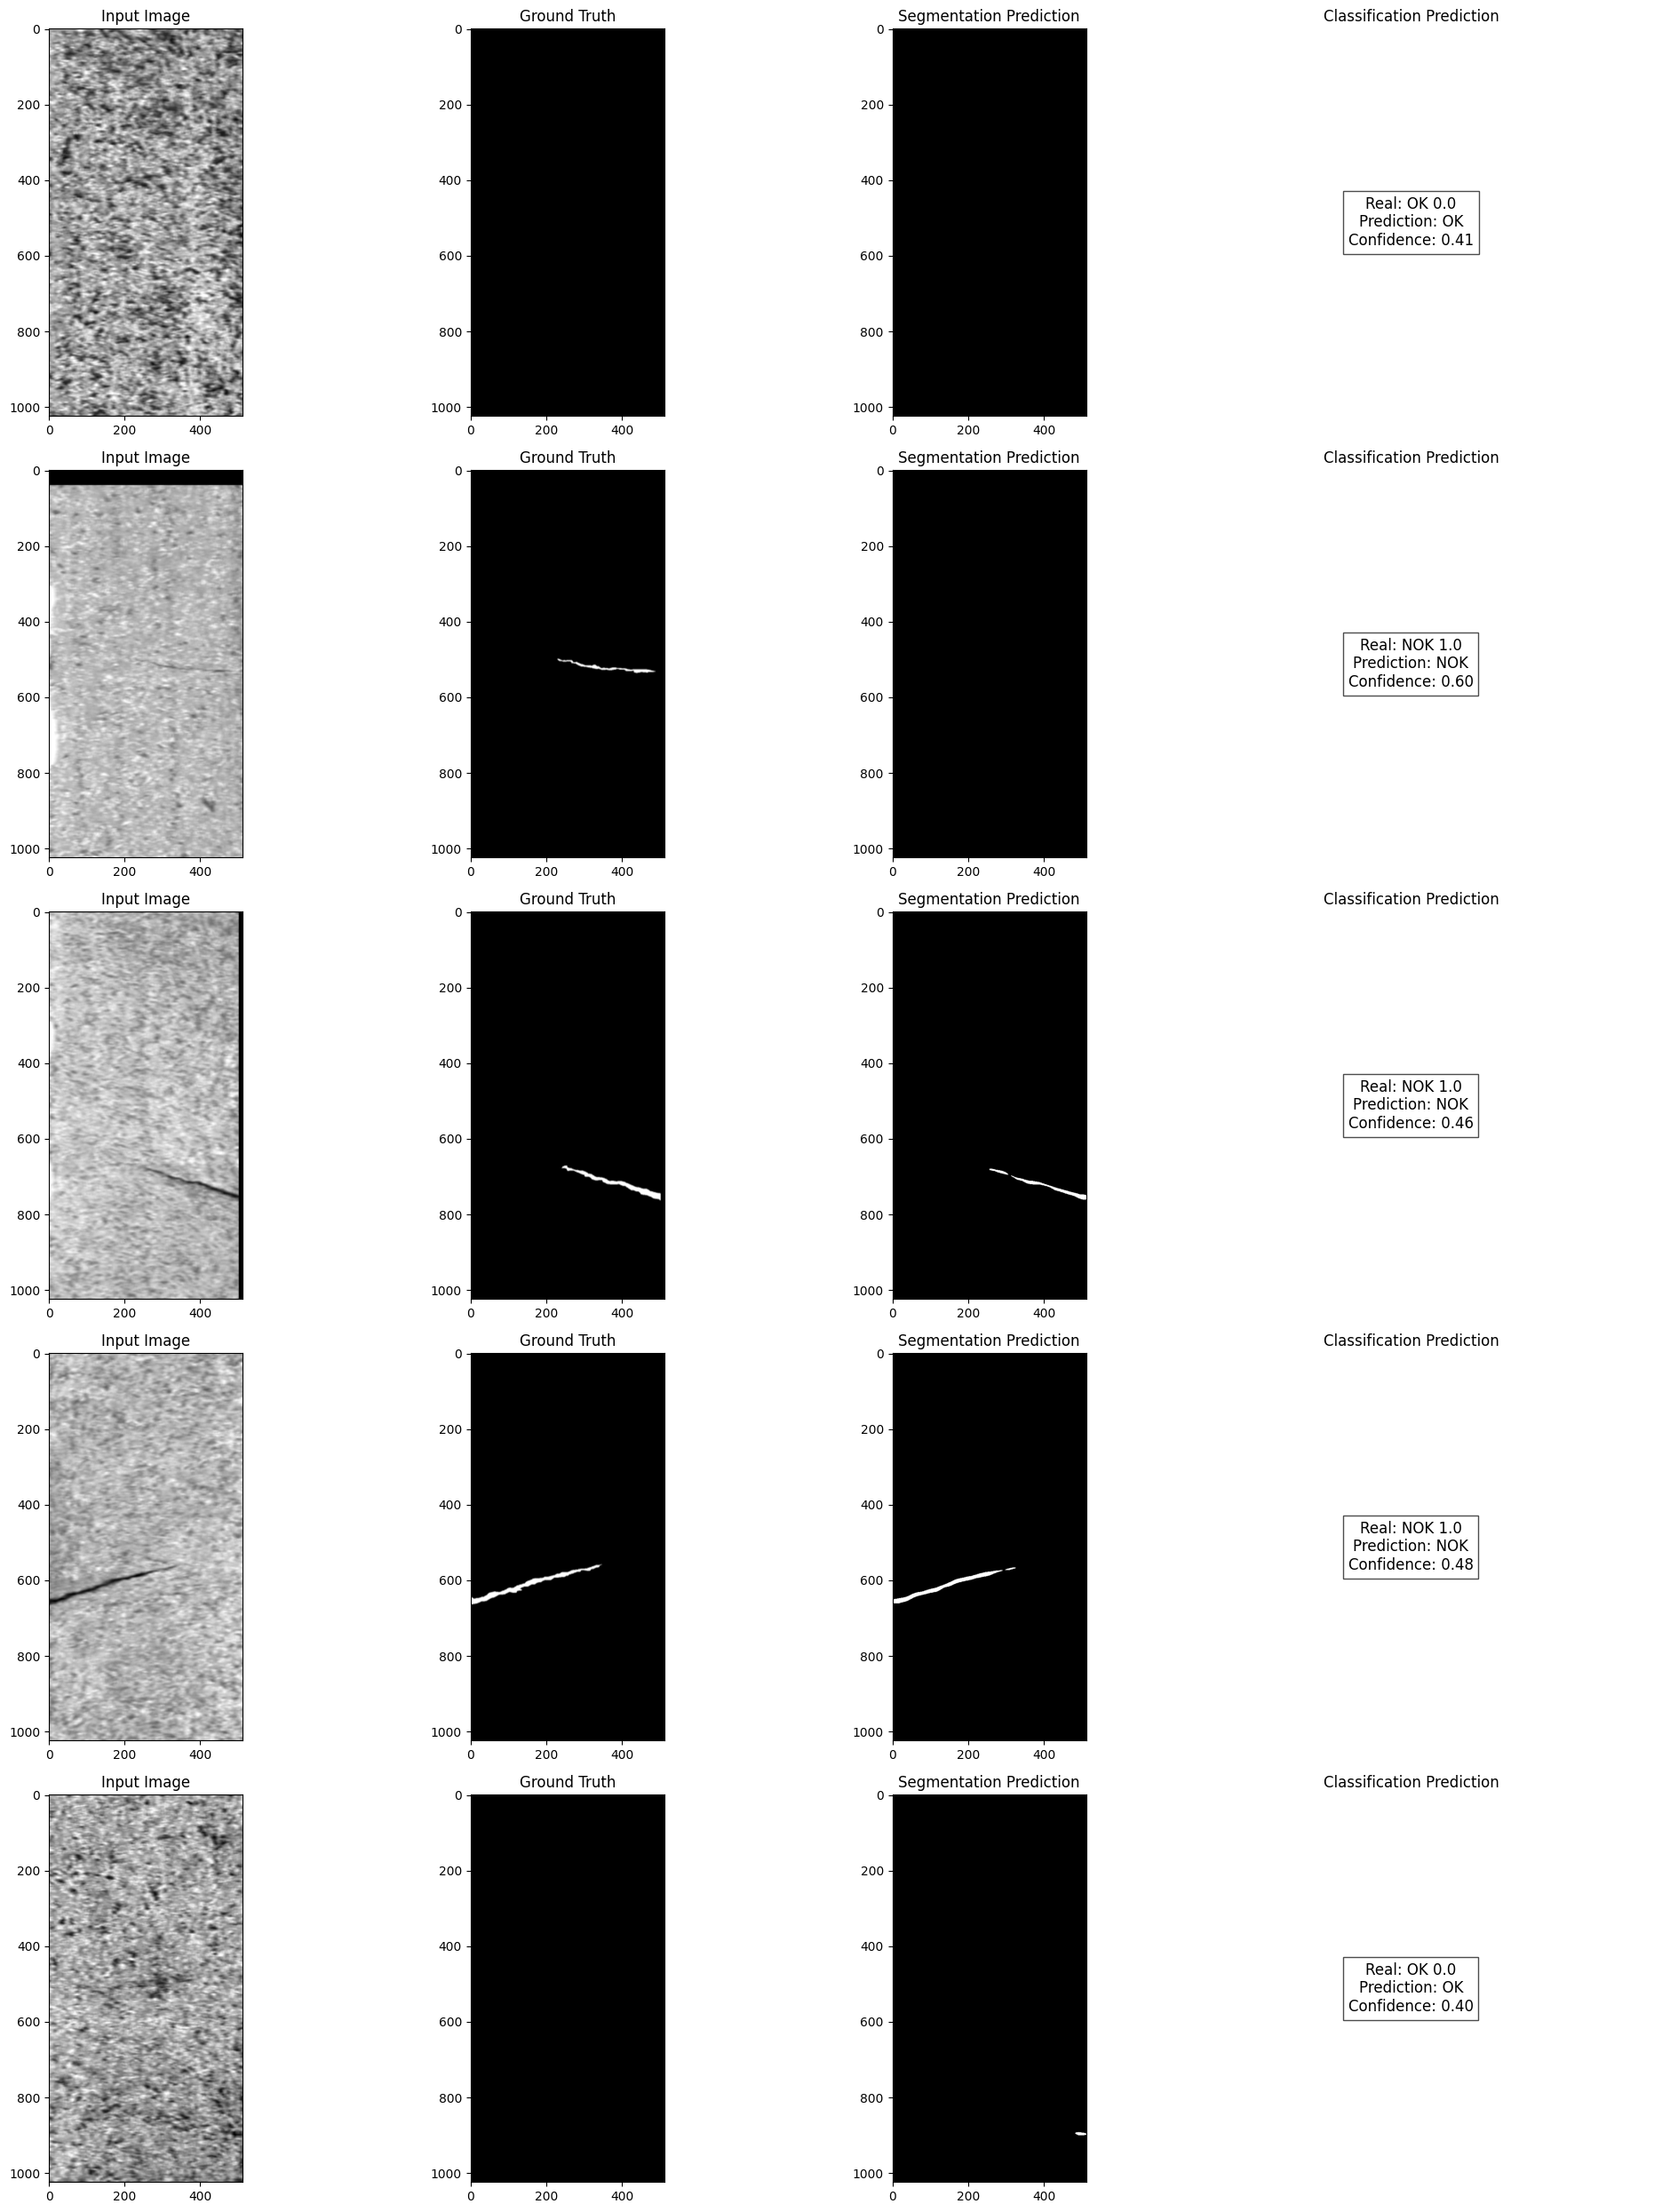

In [9]:
def visualize_predictions(model, data_loader, num_samples=3, threshold=0.01):
    """
    Visualiza las imágenes, etiquetas reales y predicciones del modelo.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        data_loader (DataLoader): DataLoader con las imágenes y etiquetas.
        num_samples (int): Número de muestras a visualizar.
        threshold (float): Umbral para binarizar las predicciones.
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    for i, (image, (segmentation_label, classification_label)) in enumerate(data_loader):
        if i >= num_samples:
            break

        with torch.no_grad():
            segmentation_pred, classification_pred = model(image.to(DEVICE))
            segmentation_pred = torch.sigmoid(segmentation_pred).cpu()  # Aplicar Sigmoid
            segmentation_pred = (segmentation_pred > threshold).float()  # Binarizar las predicciones

            classification_pred = torch.sigmoid(classification_pred).cpu().numpy()  # Aplicar Sigmoid
            classification_pred_label = (classification_pred > 0.45).astype(int)  # Binarizar predicción

        # Convertir tensores a arrays NumPy
        image_np = image[0].squeeze().cpu().numpy()
        segmentation_label_np = segmentation_label[0].squeeze().cpu().numpy()
        segmentation_pred_np = segmentation_pred[0].squeeze().cpu().numpy()

        # Mostrar imágenes, etiquetas y predicciones
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title('Input Image')
        
        axes[i, 1].imshow(segmentation_label_np, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        
        axes[i, 2].imshow(segmentation_pred_np, cmap='gray')
        axes[i, 2].set_title('Segmentation Prediction')
        
        axes[i, 3].text(
            0.5, 0.5, 
            f'Real: {"NOK" if classification_label[0][0] else "OK"} {classification_label[0][0]}\nPrediction: {"NOK" if classification_pred_label[0][0] else "OK"}\nConfidence: {classification_pred[0][0]:.2f}',
            fontsize=12, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7)
        )
        axes[i, 3].set_title('Classification Prediction')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Pruebas"  
(images, segmentation_labels, classification_labels,
 images_augmented, segmentation_labels_augmented, classification_labels_augmented) = load_dataset(root_dir)
# Imprimir información del dataset
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas de segmentacion cargadas: {len(segmentation_labels)}")
print(f"Número de etiquetas de clasificacion cargadas: {len(classification_labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas de segmentacion augmented cargadas: {len(segmentation_labels_augmented)}")
print(f"Número de etiquetas de clasificacion augmented cargadas: {len(classification_labels_augmented)}")
images = [img / 255.0 for img in images]
labels = [label / 255.0 for label in segmentation_labels]
evaluacion_dataset = CustomDataset(
    images=images,
    segmentation_labels=labels,
    classification_labels=classification_labels,
    transform=transform,
    label_transform=label_transform
)

evaluacion_loader = DataLoader(evaluacion_dataset, batch_size=1, shuffle=True)
visualize_predictions(model, test_loader, num_samples=5, threshold=0.5)